# Permit Type Classification Final Model Training

## Description


 The purpose of this model is classify construction permit types into four categories given a string input of the permit description or any notes regarding the permit. The four categories are electrical, building, mechanical, and plumbing. The core of the model is the BERT deep learning model developed by Google. 

## Data 

The data used for training were collected from three cities in the United States sourcing from public city records. The cities are Boston, Austin, and San Francisco. The raw permit data have been normalized to fit within one of the four labels. For example, the Boston dataset originally contained 14 permit classes. Those classes are mapped to the four categories eletrical, building, mechanical, and plumbing. The original datasets are additionally processed to remove incomplete data points. Only the permit description are used to train the model. 


## Training

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization

import matplotlib.pyplot as plt
print('Tensorflow version: ', tf.__version__)
print('GPU available: ', tf.config.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
### data ###
data_dir = "training_v4"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [3]:
### data reorganization ###
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3455510 files belonging to 4 classes.
Using 2764408 files for training.
Found 3455510 files belonging to 4 classes.
Using 691102 files for validation.
Found 863726 files belonging to 4 classes.


In [4]:
### viewing sample data ###
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Description: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Description: b'Foundation repair on the existing single family residence'
Label : 0 (building_permit)
Description: b'automatic fire sprklrs'
Label : 0 (building_permit)
Description: b'Replacing HVAC to existing residence only'
Label : 2 (mechanical_permit)


In [5]:
### BERT model ###
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
model_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
model_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [6]:
bert_preprocess_model = hub.KerasLayer(model_preprocess)

In [7]:
bert_model = hub.KerasLayer(model_encoder)

In [8]:
### Building classifier ###
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(model_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(model_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(4, activation=tf.nn.softmax, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

In [9]:
### Train the model ###

checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {model_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs, callbacks=[cp_callback])

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
43194/43194 [==============================] - 27043s 626ms/step - loss: 0.9995 - accuracy: 0.7277 - val_loss: 0.9792 - val_accuracy: 0.7466

Epoch 00001: saving model to checkpoints\cp.ckpt
Epoch 2/2
43194/43194 [==============================] - 24529s 568ms/step - loss: 0.9776 - accuracy: 0.7472 - val_loss: 0.9747 - val_accuracy: 0.7493

Epoch 00002: saving model to checkpoints\cp.ckpt


13496/13496 [==============================] - 5021s 372ms/step - loss: 0.9753 - accuracy: 0.7484
Loss: 0.9753215312957764
Accuracy: 0.7483692765235901
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


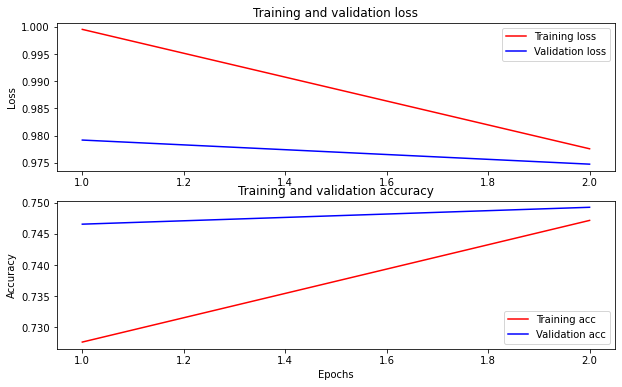

In [10]:
### Model evaluation ###

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [11]:
### Save the model ###

dataset_name = 'final_ds'
saved_model_path = './{}_modelv2'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path)

INFO:tensorflow:Assets written to: ./final_ds_modelv2\assets


INFO:tensorflow:Assets written to: ./final_ds_modelv2\assets


In [12]:
### Reload model ###

reloaded_model = tf.saved_model.load(saved_model_path)

In [13]:
### Test results ###

import numpy as np

def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'work for Blue Bottle Cafe RTU connection',
    'Install toilet  sink  lavs  shower  laundry and water heater.',
    'Residential Parking,use of premises for;1 car parking with new driveway  eplan',
    'Low Voltage,To install an intercom door bell system and security camera in the buildingTo install TV cable  in all three floor',
    'Relocate existing smoke detectors and horn/strobes. Install additional smoke detectors and horn/strobes for new 5th. floor office lay-out.'
]

# reloaded_results = reloaded_model(tf.constant(examples))
original_results = classifier_model(tf.constant(examples))
print(class_names)
print(original_results)
print('Results:')
max_ind = np.argmax(original_results.numpy(), axis=1)
for idx in max_ind:
    print('\t',class_names[idx])


['building_permit', 'electrical_permit', 'mechanical_permit', 'plumbing_permit']
tf.Tensor(
[[3.9970190e-03 3.9503184e-01 3.7216574e-01 2.2880541e-01]
 [1.2607602e-06 1.1482143e-06 6.6497921e-07 9.9999690e-01]
 [9.9999845e-01 6.7499758e-07 3.6527504e-07 4.4005273e-07]
 [4.5985971e-06 9.9998891e-01 4.8684064e-06 1.5972811e-06]
 [1.7678980e-05 9.9997532e-01 6.2763529e-06 7.7038032e-07]], shape=(5, 4), dtype=float32)
Results:
	 electrical_permit
	 plumbing_permit
	 building_permit
	 electrical_permit
	 electrical_permit


In [44]:
history = reloaded_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=1)

AttributeError: '_UserObject' object has no attribute 'fit'